In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sns

import scanpy as sc
import scanpy.external as sce
import anndata as ad

import session_info
import warnings
from pyprojroot.here import here

import scienceplots
from sklearn.neighbors import NearestNeighbors
from typing import Iterable
import pickle
from matplotlib.backends.backend_pdf import PdfPages


# Setting some parameters
warnings.filterwarnings("ignore")
sys.path.insert(1, str(here('bin')))

# Import custom functions
from customPythonFunctions import *

print("Main directory path: {}".format(here()))

plt.style.use(['nature'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

Main directory path: /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas


**Setting parameters** 

In [2]:
overwriteFigures = True
overwriteData = True

In [3]:
cellGroup = 'T_NonNaive'
workDir = os.getcwd()

**Load data**

In [ ]:
# Load the scvi h5ad file
adata = sc.read_h5ad(here("{}/results/03_{}_scVI_UMAP_clinical_allGenes.h5ad".format(workDir, cellGroup)))
adata.uns['log1p'] = dict()
adata.uns['log1p']['base'] = None # only if logscale is computed
adata

**Loading gene dictionary**

In [ ]:
with open(here('external_reference_data/markerGenes_dictionary.pkl'), 'rb') as f:
    marker_genes_dict = pickle.load(f)

In [ ]:
canonical_marker_gene_list = [g for g in marker_genes_dict['lineages'].values() for g in g if g in adata.var.symbol.values]

if cellGroup in marker_genes_dict:
    lineage_marker_gene_list = set([g for g in marker_genes_dict[cellGroup].values() for g in g if g in adata.var.symbol.values])
else: 
    lineage_marker_gene_list = None

**Plotting parameters** 

In [ ]:
max_cells_plot = 200000
fraction = min(1, (max_cells_plot/adata.shape[0]))

# Clustering

First, we cluster the cells from the integrated dataset using the Leiden algorithm; this step will allow us to identify cellular structure in the dataset based on the cells' transcriptomic profile. 
In our case, we will try different low resolution parmeters to control the coarseness of the clustering, and to define the major cellular lineages, which will be further explored and clustered independently.

Following best practices: https://www.sc-best-practices.org/cellular_structure/clustering.html

Then, we can visualize and explore the different clustering results obtained at different resolutions, as well as evaluate the covariate distribution across the different clusters of interest.

In [ ]:
# Resolutions of interest
resolutions_to_explore = [0.1, 0.25, 0.5, 0.75, 1]
# Co-variables of interest
list_of_variables = [ "batches", "disease", "binned_age", "sex" ]

In [ ]:
for res in resolutions_to_explore:
    leiden_cluster = "leiden_res_" + str(res)
    
    # Clustering
    sc.tl.leiden(adata, resolution=res, key_added=leiden_cluster, neighbors_key='scVI')

    if overwriteFigures:
        
        # Explore clustering
        # Subsetting and randomizing for optimal plotting
        random_indices = balanced_sample(adata.obs, cols = leiden_cluster, frac = fraction, shuffle = True, random_state = 42).cellID
        
        sc.set_figure_params(figsize=(7, 5))
        fig = sc.pl.embedding(adata[random_indices, :], basis="X_umap_scVI", color=leiden_cluster, show=True, return_fig=True, size=10, legend_loc="on data")
        plt.savefig(here('{}/results/figures/UMAP_clusters_res{}.pdf'.format(workDir, res)), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)

        # Evaluate co-variables distribution across clusters
        pdf_pages = PdfPages(here("{}/results/figures/Barplots_covariates_across_clusters_{}.pdf".format(workDir, res)))
        for variable in list_of_variables:
            sc.set_figure_params(figsize=(10, 5))
            composition_barplot(adata, xattr=leiden_cluster, yattr=variable, title="Distribution of {}".format(variable), save_pdf=pdf_pages)
        pdf_pages.close()

In [ ]:
adata

## Save clustered object

In [ ]:
if overwriteData:
    clusterDF = adata.obs[['leiden_res_{}'.format(r) for r in resolutions_to_explore]]
    # Save clustering as DF
    clusterDF.to_pickle(path=here('{}/results/SCGT00_clustering_resolutions_to_explore.pkl'.format(workDir)))

# Known marker genes visualization

## Explore canonical marker genes

In [ ]:
# Subsetting and randomizing for optimal plotting
random_indices = balanced_sample(adata.obs, cols = ["sampleID"], frac = fraction, shuffle = True, random_state = 42).cellID
ID2SymbolDF = generateID2SymbolDF(varDF = adata[random_indices, :].var, symbolList = canonical_marker_gene_list, ID_col = 'index', symbols_col = 'symbol', HUGOstatus_col = 'HUGO_status', behaviour = 'all')

# FeaturePlot
sc.set_figure_params(figsize=(4, 4))
fig = sc.pl.embedding(basis = 'X_umap_scVI', 
                adata = adata[random_indices, :], 
                color=ID2SymbolDF["gene_id"], title= ID2SymbolDF["symbol"], s=10, 
                frameon=False, ncols=6,
                use_raw=False, 
                show=False, return_fig=False)

if overwriteFigures:
    plt.savefig(here('{}/results/figures/UMAP_CanonicalMarkers.pdf'.format(workDir)), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)

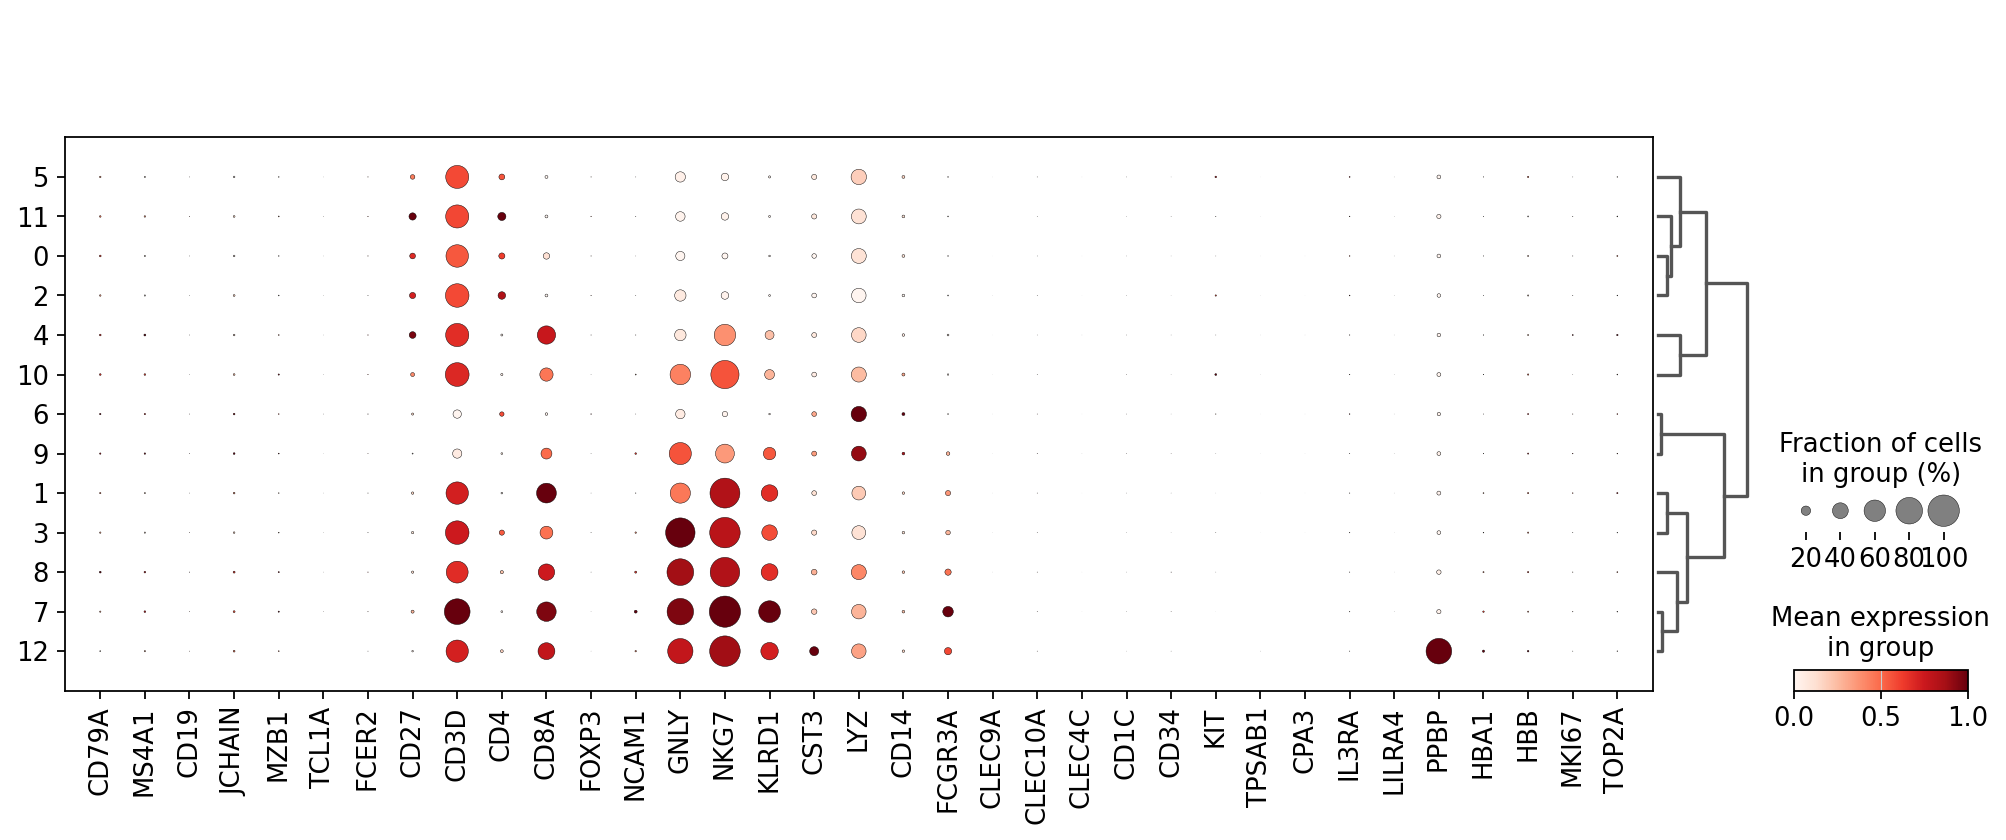

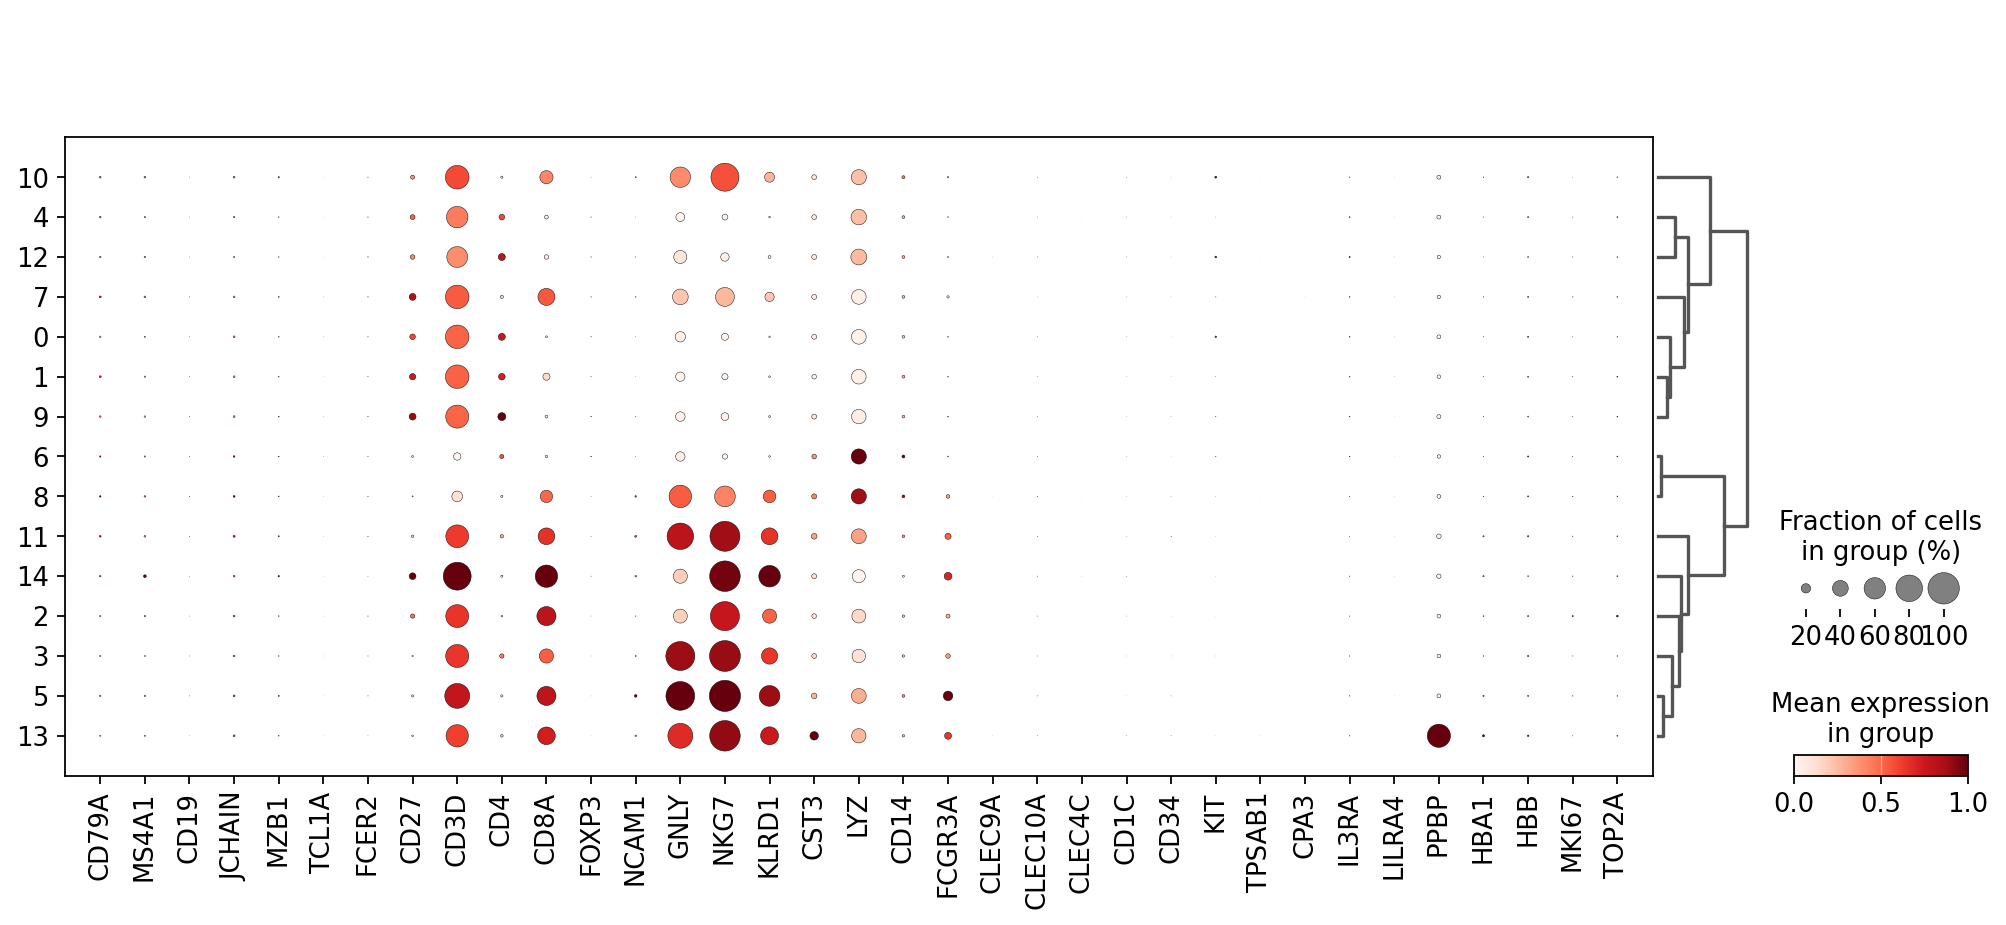

In [ ]:
for res in resolutions_to_explore:
    leiden_cluster = "leiden_res_" + str(res)
    
    # Subsetting and randomizing for optimal plotting
    random_indices = balanced_sample(adata.obs, cols = leiden_cluster, frac = fraction, shuffle = True, random_state = 42).cellID
    ID2SymbolDF = generateID2SymbolDF(varDF = adata[random_indices, :].var, symbolList = canonical_marker_gene_list, 
                                      ID_col = 'index', symbols_col = 'symbol', HUGOstatus_col = 'HUGO_status', behaviour = 'all')
    
    # Dotplot
    sc.set_figure_params(figsize=(15, 7))
    fig = sc.pl.dotplot(adata[random_indices, :],
                        var_names = ID2SymbolDF["gene_id"],
                        groupby=leiden_cluster, standard_scale='var', 
                  use_raw = False, dendrogram=True, show=False, return_fig=False)
        # replace ensembls ids by gene symbol in plot
    _ = fig['mainplot_ax'].set_xticklabels(ID2SymbolDF["symbol"])
    
    if overwriteFigures:
        plt.savefig(here('{}/results/figures/Dotplot_CanonicalMarkers_res{}.pdf'.format(workDir, res)), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)

## Explore LINEAGE-specific canonical marker genes

In [ ]:
if lineage_marker_gene_list:
    random_indices = balanced_sample(adata.obs, cols = ["sampleID"], frac = fraction, shuffle = True, random_state = 42).cellID
    ID2SymbolDF = generateID2SymbolDF(varDF = adata.var, symbolList = lineage_marker_gene_list, ID_col = 'index', symbols_col = 'symbol', HUGOstatus_col = 'HUGO_status', behaviour = 'all')

    sc.set_figure_params(figsize=(7, 5))
    fig = sc.pl.embedding(adata = adata[random_indices, :], 
                          basis="X_umap_scVI", 
                          color=ID2SymbolDF["gene_id"], title= ID2SymbolDF["symbol"], s=10, 
                          show=True, 
                          return_fig=True, 
                          size=30, 
                          legend_loc="on data", 
                          use_raw=False)

    if overwriteFigures:
        plt.savefig(here('{}/results/figures/UMAP_SublineageMarkers.pdf'.format(workDir)), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)   

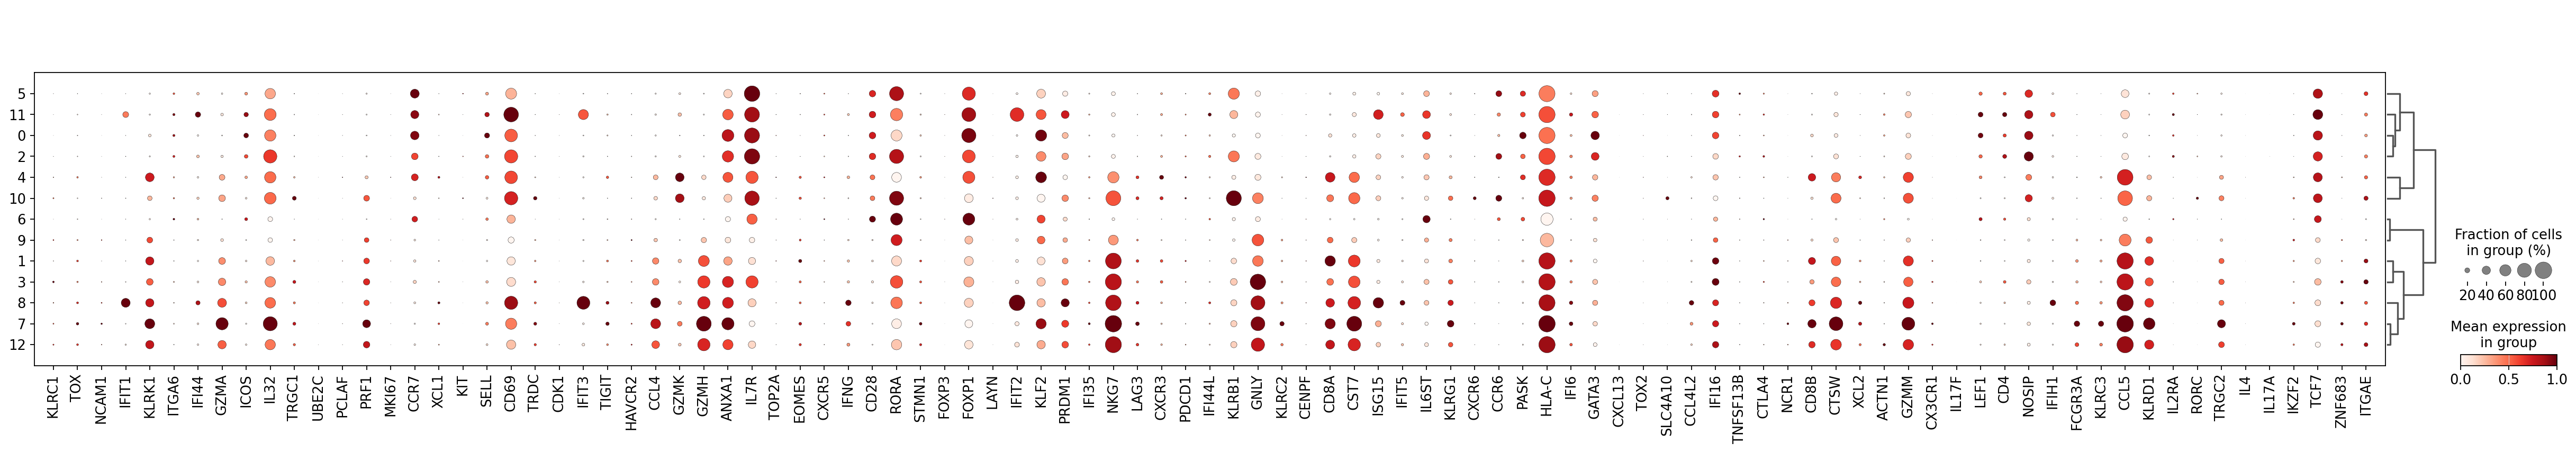

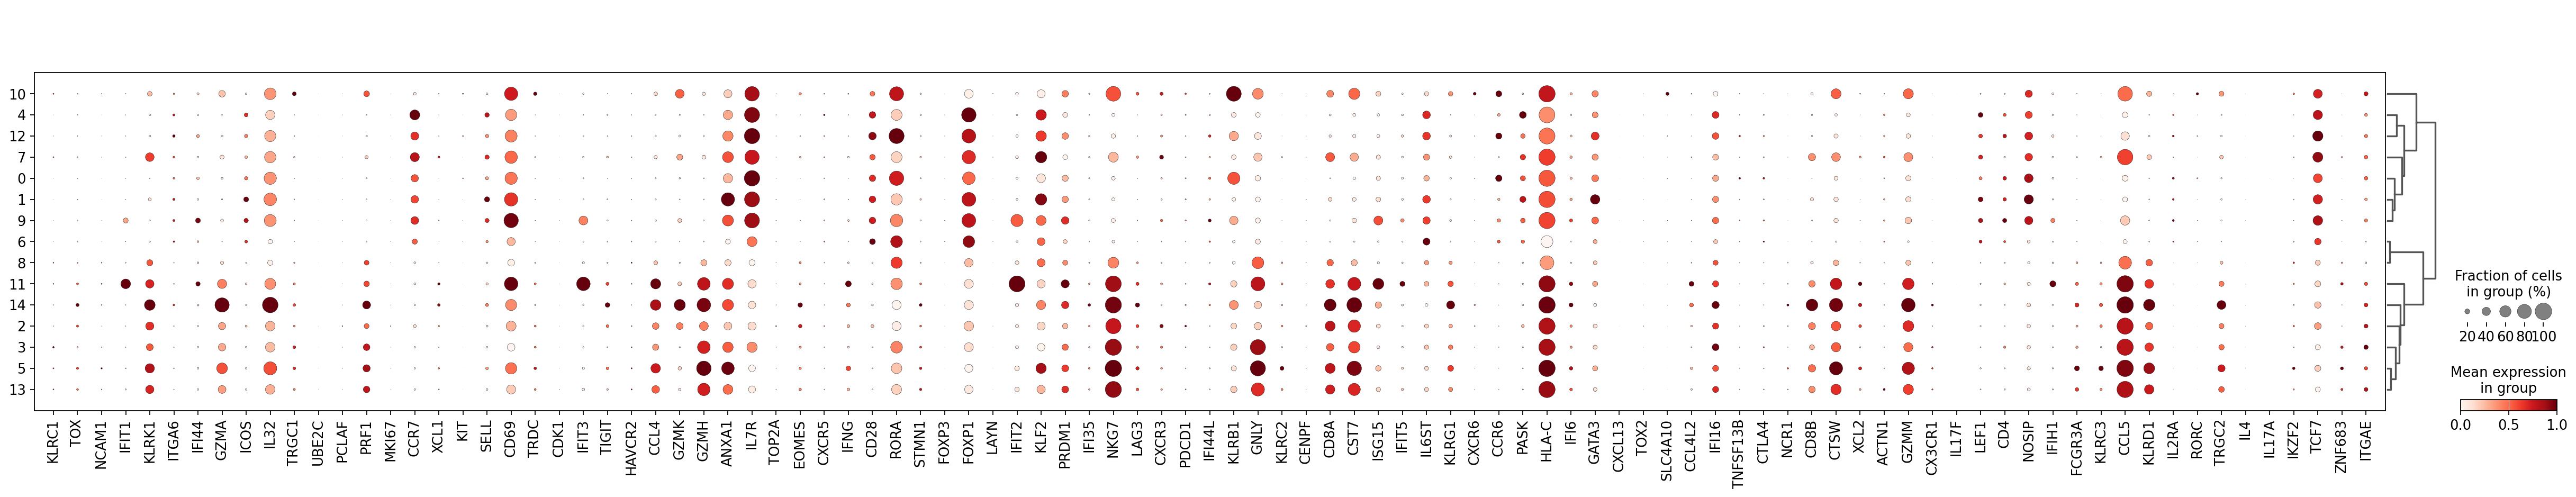

In [ ]:
if lineage_marker_gene_list:
    for res in resolutions_to_explore:
        leiden_cluster = "leiden_res_" + str(res)
        
        # Subsetting and randomizing for optimal plotting
        random_indices = balanced_sample(adata.obs, cols = leiden_cluster, frac = fraction, shuffle = True, random_state = 42).cellID
        ID2SymbolDF = generateID2SymbolDF(varDF = adata[random_indices, :].var, symbolList = lineage_marker_gene_list, 
                                          ID_col = 'index', symbols_col = 'symbol', HUGOstatus_col = 'HUGO_status', behaviour = 'all')
        
        # Dotplot
        sc.set_figure_params(figsize=(15, 7))
        fig = sc.pl.dotplot(adata[random_indices, :],
                            var_names = ID2SymbolDF["gene_id"],
                            groupby=leiden_cluster, standard_scale='var', 
                      use_raw = False, dendrogram=True, show=False, return_fig=False)
            # replace ensembls ids by gene symbol in plot
        _ = fig['mainplot_ax'].set_xticklabels(ID2SymbolDF["symbol"])
        
        if overwriteFigures:
            plt.savefig(here('{}/results/figures/Dotplot_SublineageMarkers_res{}.pdf'.format(workDir, res)), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)

In [ ]:
session_info.show()